In [1]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F


In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    for result in executor.map(read_ladris_from_db, queries):
        comb_scenarios.update(result)

print(len(comb_scenarios))

2000


In [5]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)

In [6]:
df.head()

,330221,334722,329174,344238,328156,336153,341386,342952,329091,329644,...,332329,338651,334250,335451,342669,341295,329502,341121,333480,343388
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,1,0,1,0,1,...,1,1,1,1,1,0,0,0,0,0
2,0,0,1,1,1,1,1,0,0,1,...,1,0,1,1,1,1,1,1,1,1
3,1,0,0,0,0,1,1,0,0,1,...,0,1,0,0,0,1,1,1,0,1
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,1,0,1,1,0,1


In [7]:
df_results

,0
0,5.249842
1,3.879646
2,3.844590
3,4.652006
4,3.765344
...,...
1995,4.119792
1996,4.583354
1997,5.270471
1998,3.792136


In [8]:
quantileDF = df_results[0].quantile([0.1, 0.15, 0.2, .25, 0.3, 0.35, 0.4, .45, .5, 0.55, .65, .75, 0.85, 0.95])
print(quantileDF)

### print quantile 0.65 of quantileDF
print(quantileDF[0.65])

0.10    3.754970
0.15    3.764693
0.20    3.771590
0.25    3.779961
0.30    3.788202
0.35    3.796031
0.40    3.814604
0.45    3.877674
0.50    4.120497
0.55    4.134627
0.65    4.346542
0.75    4.910395
0.85    5.300732
0.95    6.138637
Name: 0, dtype: float64
4.346542208333333


In [9]:
experiments = df
### Create outcomes as an array of df_results
outcomes = list(df_results[0].values)

# Reduction and better use of inputs

The input set is so large and uniform that the noise is too great. Signal needs to be extracted prior to training a transformer otherwise the transformer takes way to long to train and its outputs tend to be the mean of the uniform dataset instead of good predictions. This also indicates that is training on the noise rather than the characteristics of the dataset that we are trying to discover.

To reduce the input set the objective needs to be clear. There is interest in understanding the effects of the inputs to the outputs, and there is interest in understanding how the inputs effect each other to contribute to the effect on the outputs. This two part problem can be described as a feature importance problem and a feature correlation problem. To identify feature importance xgboost is used to define random forests in which key features can be measured and sorted. Feature correlation is done by calculating a correlation matrix using numpy.

- The feature importance highlights the features that have the largest effect on the outputs
- The correlation matrix highlights the features that tend to change with and against each other of the sample...

In the end this will get us the features that are important and the features associated with each important feature. Then we can build data sets to train the transformer based on data of the important features supplemented with the features that tend to effect them as well.

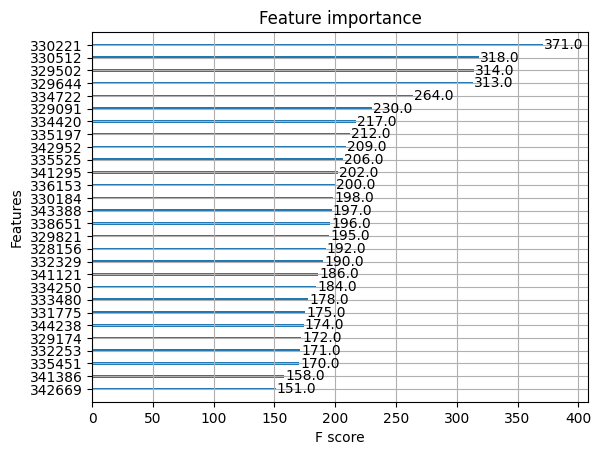

In [10]:
### perform feature importance on experiments based on outcomes with xgboost
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBRegressor()
model.fit(experiments, outcomes)
plot_importance(model)
pyplot.show()


In [11]:
### Print the highest scoring features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature ranking:')
for f in range(experiments.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], experiments.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 0 330221 (0.345745)
2. feature 9 329644 (0.150030)
3. feature 16 330512 (0.118741)
4. feature 1 334722 (0.080017)
5. feature 24 329502 (0.076319)
6. feature 15 334420 (0.052967)
7. feature 8 329091 (0.050433)
8. feature 20 334250 (0.044910)
9. feature 23 341295 (0.040819)
10. feature 13 329821 (0.005162)
11. feature 14 335197 (0.003473)
12. feature 3 344238 (0.002738)
13. feature 12 330184 (0.002527)
14. feature 26 333480 (0.002359)
15. feature 11 331775 (0.002357)
16. feature 5 336153 (0.002180)
17. feature 22 342669 (0.002054)
18. feature 2 329174 (0.001968)
19. feature 21 335451 (0.001938)
20. feature 19 338651 (0.001905)
21. feature 25 341121 (0.001741)
22. feature 10 332253 (0.001519)
23. feature 27 343388 (0.001419)
24. feature 18 332329 (0.001412)
25. feature 7 342952 (0.001405)
26. feature 4 328156 (0.001400)
27. feature 17 335525 (0.001236)
28. feature 6 341386 (0.001226)


In [14]:
### get the feature ids of the features with importance > 0.001
feature_ids = []
for i in range(experiments.shape[1]):
    if importances[i] > 0.00001:
        feature_ids.append(i)
print(feature_ids)
print(len(feature_ids))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
28


In [15]:
### print the indexes of outcomes that are greater than the 0.75 quantile
outcomes_index = []
for i in range(len(outcomes)):
    if outcomes[i] > quantileDF[0.75]:
        outcomes_index.append(i)
print(len(outcomes_index))

500


# Correlation calculations

The correlation is now calculated from experiments for index values that are greater than the 75% quantile. The diagonal is then removed so that descriptive statistics can be derived without the self correlation value. An absolute value correlation matrix is recorded so that correlation magnitude can be utilized for comparison purposes. Finally, descriptive dataframes are created for both regular correlation matrix and absolute value correlation matrix to allow fast look up of correlation value ranges per feature.

In [16]:
### calculate the correlation matrix of experiments for outcomes_index
correlation_matrix = experiments.iloc[outcomes_index].corr()
print(correlation_matrix)

### remove the diagonal from the correlation_matrix
correlation_matrix = correlation_matrix - np.eye(correlation_matrix.shape[0])
print(correlation_matrix)

### create a copy of the correlation_matrix with absolute values
abs_correlation_matrix = np.abs(correlation_matrix)
print(abs_correlation_matrix)

### print descriptive statistics of the correlation_matrix absolute values
cor_desc = pd.DataFrame(correlation_matrix).describe()
abs_desc = pd.DataFrame(abs_correlation_matrix).describe()
print(abs_desc)


          330221    334722    329174    344238    328156    336153    341386  \
330221  1.000000  0.198336  0.029143 -0.025150  0.078948 -0.022307  0.050344   
334722  0.198336  1.000000 -0.028767 -0.052085 -0.025350 -0.048635  0.010405   
329174  0.029143 -0.028767  1.000000 -0.004097  0.084290  0.063886  0.004197   
344238 -0.025150 -0.052085 -0.004097  1.000000  0.049223 -0.005062  0.065246   
328156  0.078948 -0.025350  0.084290  0.049223  1.000000 -0.041977  0.109949   
336153 -0.022307 -0.048635  0.063886 -0.005062 -0.041977  1.000000 -0.041977   
341386  0.050344  0.010405  0.004197  0.065246  0.109949 -0.041977  1.000000   
342952  0.006292 -0.003950  0.039863 -0.069143  0.046210  0.006076 -0.001892   
329091 -0.014975  0.115589 -0.001258 -0.036910 -0.073045  0.028121 -0.047857   
329644 -0.104828 -0.277506 -0.085121  0.097309  0.010915  0.002938 -0.014273   
332253 -0.060012 -0.052598  0.064093 -0.091565 -0.037010  0.064956  0.027077   
331775 -0.048659  0.014937  0.039832  0.

In [18]:
### print feature for index 72
print(experiments.columns[20])

334250


In [19]:
cor_desc[329173]

KeyError: 329173

In [20]:
### convert correlation_matrix to a numpy array
correlation_matrix = correlation_matrix.to_numpy()

In [21]:
### get index of column 334450
index = experiments.columns.get_loc(334450)
print(index)

KeyError: 334450

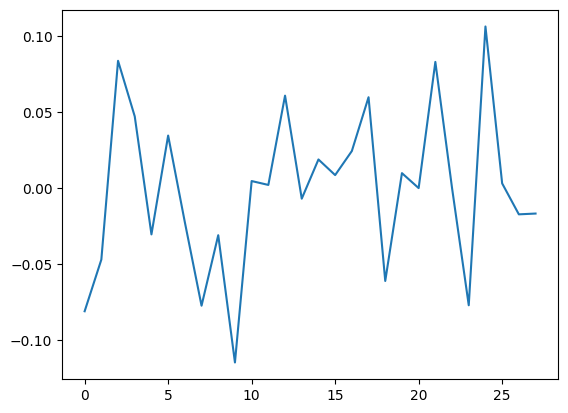

In [23]:
### plot the corelation of 72 to each feature
plt.plot(correlation_matrix[20])
### limit y axis to 0 to 0.05
#plt.ylim(-0.03, 0.05)
### highlight points in red the features with a correlation > cor_desc[8]['75%']

plt.show()

# Critical Feature Correlation
Capture all the features that are highly correlated to the most important features identified by xgboost in feature importance phase. This will give idea of what features to include in training of transformer. After measuring this does not reduce the key count at all when using all the important features. 

Scenario discovery can be attempted on the key features themselves. First we identify what the key features are, then we identify the correlated inputs to the key features, then we train the transformer on the those features for the dataset of interest, or sample from the dataset.

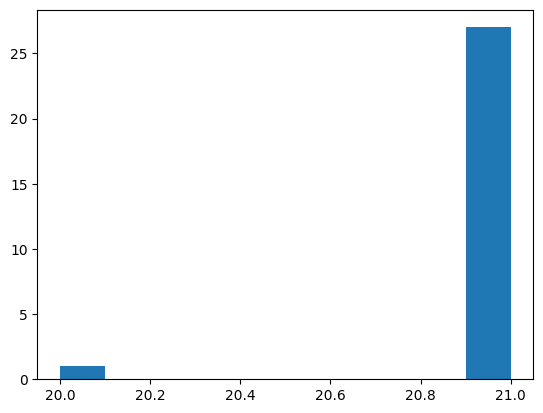

[0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26]


In [30]:
### print the idexes of correlation_matrix[72] that are greater than abs_desc[72]['75%']
correlation_index = {}
for f in feature_ids:
    for i in range(len(correlation_matrix[f])):
        if abs(correlation_matrix[f][i]) > abs_desc[experiments.columns[f]]['25%']:
            if f in correlation_index.keys():
                correlation_index[f].append(i)
            else:
                correlation_index[f] = []            
                correlation_index[f].append(i)

#### get an array of the length of each array in correlation_index
correlation_index_length = []
for f in correlation_index.keys():
    correlation_index_length.append(len(correlation_index[f]))

### plot the correlation_index_length as a histogram
plt.hist(correlation_index_length)
plt.show()

print(correlation_index[f])

In [31]:
### count how many values are in correlation_index that are not in feature_ids
index_count = []
for i in [72]:#correlation_index.keys():
    for j in correlation_index[i]:
        if j not in feature_ids:
            if j not in index_count:
                index_count.append(j)

print(len(index_count), len(correlation_index.keys()), len(df.columns), (len(index_count) + len(correlation_index.keys()))/len(df.columns))


KeyError: 72

# Training Data

For a feature (f) from feature_ids (the feature importance index list), create a subset of the training data associated with the outcomes of interest (high critical), then extract the features from feature_ids + index_count (the identified correlated features) for a subset of inputs to be considered for the transformer.

This will generate a trainin set that is composed of more signal with the hopes that the transformer will pick up the relationship of the important features and the dimension of correlated features for (f).

In [32]:
print(len(feature_ids))
print(feature_ids)

28
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


# Aggregate the input data
Divide the input data up into sections per evacuation route. Top, Middle, Bottom for each evacuation route. Then categorize the road closed segments based on the aggregated areas and have the model sample within the areas.

In [37]:
### create a subset of 600 features (400 from feature_ids, 200 index_count for the selected feature_ids)
subset = []
### choose 400 features randomly from feature_ids
import random
random.seed(1)
subset = random.sample(feature_ids, 20)
### choose 200 features randomly from subset
sub_subset = random.sample(subset, 20)
### for each sub_subset feature get a random index_count feature
for i in sub_subset:
    ### get a random index_count[i] feature
    subset.append(random.choice(correlation_index[i]))
print(len(subset))
print(subset[:10])


40
[4, 18, 25, 24, 2, 8, 3, 15, 14, 20]


In [38]:
subset_index = subset #list(set(index_count + feature_ids))
experiments.shape

(2000, 28)

In [39]:
### combine the unique index values of correlation_index[72] and feature_ids
subset_index = subset #list(set(index_count + feature_ids))

### create a subset of experiments with columnms defined in subset_index
subset_experiments = experiments.iloc[outcomes_index, subset_index]

subset_outcomes = [outcomes[i] for i in outcomes_index]
### just get the rows from outcomes_index of the subset_experiments
#subset_experiments = subset_experiments.iloc[outcomes_index].to_numpy()

### just get the rows from outcomes_index of the subset_experiments
#subset_outcomes = [outcomes[i] for i in outcomes_index]


In [40]:
print(subset_experiments.shape)
print(len(subset_outcomes))

(500, 40)
500


In [41]:
print(len(subset_experiments), len(subset_outcomes))
subset_outcomes

500 500


[5.249841666666667,
 5.247785277777777,
 5.243493611111111,
 5.682940555555556,
 5.4386553611111115,
 5.245733472222223,
 5.23947,
 9.29459097222222,
 5.076170194444445,
 5.2915803611111105,
 5.451965111111111,
 5.200116944444445,
 5.2460049444444445,
 5.2390727777777775,
 5.8245395,
 5.375782583333333,
 7.93761125,
 7.811098611111111,
 5.514897666666667,
 9.506362555555558,
 7.942330833333333,
 5.474676666666666,
 5.3447411111111105,
 9.098466666666669,
 6.4325185000000005,
 5.2962983333333336,
 5.037192805555555,
 4.954151500000001,
 5.526106777777779,
 9.239151944444444,
 5.706970111111111,
 5.308910444444445,
 5.513751111111111,
 5.249271111111112,
 5.781872555555556,
 5.032554166666666,
 5.021744444444445,
 9.26534611111111,
 9.28510488888889,
 5.222763888888889,
 5.837826333333334,
 5.254187416666667,
 5.758699444444444,
 5.585106944444444,
 5.474442222222223,
 5.588276388888889,
 5.24049788888889,
 6.720411333333334,
 5.256325333333334,
 5.931756666666667,
 8.026932222222221,
 4

(array([233., 147.,  38.,  13.,   2.,   1.,  31.,   0.,  18.,  17.]),
 array([4.91118542, 5.39376499, 5.87634456, 6.35892412, 6.84150369,
        7.32408326, 7.80666283, 8.2892424 , 8.77182197, 9.25440154,
        9.73698111]),
 <BarContainer object of 10 artists>)

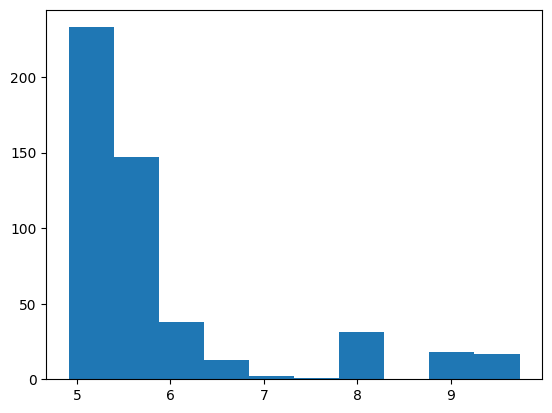

In [42]:
### Plot a histogram of subset_outcomes
plt.hist(subset_outcomes)

In [43]:
### get subset_experiments for indexs of outcomes_index
subset_experiments = torch.tensor(subset_experiments.to_numpy(), dtype=torch.float32)

### convert outcomes into a 2d binary tensor
subset_outcomes = torch.tensor(subset_outcomes, dtype=torch.float32)

In [44]:
subset_outcomes

tensor([5.2498, 5.2478, 5.2435, 5.6829, 5.4387, 5.2457, 5.2395, 9.2946, 5.0762,
        5.2916, 5.4520, 5.2001, 5.2460, 5.2391, 5.8245, 5.3758, 7.9376, 7.8111,
        5.5149, 9.5064, 7.9423, 5.4747, 5.3447, 9.0985, 6.4325, 5.2963, 5.0372,
        4.9542, 5.5261, 9.2392, 5.7070, 5.3089, 5.5138, 5.2493, 5.7819, 5.0326,
        5.0217, 9.2653, 9.2851, 5.2228, 5.8378, 5.2542, 5.7587, 5.5851, 5.4744,
        5.5883, 5.2405, 6.7204, 5.2563, 5.9318, 8.0269, 4.9175, 5.2249, 5.3607,
        9.7370, 5.3624, 5.4633, 5.6665, 6.7011, 4.9141, 5.3638, 7.8928, 5.4366,
        4.9407, 5.2274, 5.1886, 6.5645, 6.1963, 5.2819, 8.1281, 5.2539, 5.7219,
        5.1315, 5.5727, 5.5334, 5.2030, 5.3719, 9.1693, 5.5300, 9.2292, 5.6092,
        5.1068, 5.0948, 5.2277, 6.1784, 6.2927, 5.2380, 5.8923, 5.0117, 5.4453,
        5.8194, 6.3868, 9.1273, 5.0705, 5.0862, 5.8929, 5.2116, 5.9508, 5.5504,
        9.4613, 7.9587, 5.2479, 5.7206, 5.5726, 5.2304, 5.1187, 5.6200, 5.4955,
        5.1562, 5.8572, 5.0673, 5.2510, 

In [45]:
### print descriptive statistics of outcomes
print(subset_outcomes.mean())
print(subset_outcomes.std())
print(subset_outcomes.min())
print(subset_outcomes.max())

tensor(5.8803)
tensor(1.1710)
tensor(4.9112)
tensor(9.7370)


In [46]:
### get index values of oucomes greater than 4.1
idx = subset_outcomes > 6

### print the number of outcomes greater than 4.1
print(idx.sum())


tensor(105)


In [48]:
### select a random 100 columns from experiments
c_idx = np.random.choice(experiments.shape[1], 20, replace=False)

print(c_idx)

[ 6 26 27 14 17  9  7 12  3 18 13 16 11  0  5 20 25  8  4 15]


In [49]:
### for each column in experiments, count the columns that are always zero
zero_columns = (experiments == 0).all()
print(zero_columns.sum())

0


In [50]:
subset_experiments

tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 0., 1., 0.]])

In [51]:
inputs = subset_experiments
inputs.shape[1]

40

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example input data (6 samples, 6 features each)
#inputs = torch.tensor([
#    [0, 0, 1, 1, 0, 0],
#    [1, 0, 0, 1, 0, 0],
#    [1, 1, 1, 0, 0, 0],
#    [0, 0, 0, 1, 1, 1],
#    [1, 0, 1, 0, 1, 0],
#    [0, 1, 1, 1, 0, 0]
#], dtype=torch.float32)

#outputs = torch.tensor([2.3, 2.7, 3.4, 3.1, 2.9, 4.1], dtype=torch.float32)

### Set inputs as experiments for index values of idx and columns c_idx
inputs = subset_experiments

### Set outputs as outcomes for index values of idx
outputs = subset_outcomes

# Hyperparameters
input_dim = inputs.shape[1]  # 6 features
embedding_dim = 8  # Embedding dimension
num_heads = 8
num_layers = 2
hidden_dim = 32
learning_rate = 0.001
num_epochs = 500

# Transformer-based regression model with explanation functionality
class TransformerRegressorWithAttention(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_heads, num_layers, hidden_dim):
        super(TransformerRegressorWithAttention, self).__init__()
        
        # Embedding layer for inputs
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Pooling layer to summarize sequence
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Final regression layer
        self.regressor = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # Embedding the input features
        x = self.embedding(x.long())  # Ensure the input is long before passing through embedding
        
        # Transformer input needs the shape: [seq_len, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)  # Correctly permute to [seq_len, batch_size, embedding_dim]
        
        # Transformer encoder
        x = self.transformer(x)  # Shape: [seq_len, batch_size, embedding_dim]
        
        # Pooling across the sequence dimension
        x = x.mean(dim=0)  # Global average pooling: Shape: [batch_size, embedding_dim]
        
        # Regression output
        x = self.regressor(x)  # Shape: [batch_size, 1]
        return x.squeeze(-1)
    
    def get_attention_weights(self, x):
        # Embedding the input features
        x = self.embedding(x.long())  # Ensure the input is long before passing through embedding
        
        # Transformer input needs the shape: [seq_len, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)  # Correctly permute to [seq_len, batch_size, embedding_dim]
        
        # Add sequence dimension for attention computation: [seq_len, 1, batch_size, embedding_dim]
        x = x.unsqueeze(1)  # Shape: [seq_len, 1, batch_size, embedding_dim]
        
        x = x.squeeze(1)

        print(x.shape)
        
        # Transformer encoder to get attention
        transformer_output = self.transformer(x)  # This directly gets the output from the transformer
        
        # Attention weights: [seq_len, batch_size, num_heads, seq_len]
        attention_weights = transformer_output.transpose(0,1)
        
        return attention_weights

# Model, loss, and optimizer
model = TransformerRegressorWithAttention(input_dim, embedding_dim, num_heads, num_layers, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Logging
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Testing and analysis
model.eval()
with torch.no_grad():
    # Get predictions for 5 random inputs
    test_inputs = inputs[:5]
    test_predictions = model(test_inputs)
    print("\nPredictions:", test_predictions.numpy())
    print("True values:", outputs[:5].numpy())


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [50/500], Loss: 22.5648
Epoch [100/500], Loss: 17.3323
Epoch [150/500], Loss: 12.7064
Epoch [200/500], Loss: 8.7269
Epoch [250/500], Loss: 5.6137
Epoch [300/500], Loss: 3.4831
Epoch [350/500], Loss: 2.2480
Epoch [400/500], Loss: 1.6671
Epoch [450/500], Loss: 1.4505
Epoch [500/500], Loss: 1.3844

Predictions: [5.7845664 5.784566  5.7842493 5.785122  5.785781 ]
True values: [5.2498417 5.247785  5.2434936 5.6829405 5.4386554]


In [53]:
# Testing and analysis
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(inputs)
    print("\nPredictions:", test_predictions.numpy())
    
    # Extract attention weights
    attention_weights = model.get_attention_weights(inputs)
    
    # Analyze and report patterns
    seq_len = inputs.shape[1]
    for i in range(inputs.shape[0]):  # Loop over each input sample
        print(f"\nAnalyzing Sample {i+1}: {inputs[i].numpy()}")
        
        sample_attention = attention_weights[:, i]

        # Calculate average attention weights per feature
        avg_attention = sample_attention.mean(dim=-1)#.detach().numpy()  # Shape: [num_heads, seq_len]
        
        print(sample_attention.shape)
        print(avg_attention.shape)

        print(type(avg_attention))
        avg_attention = avg_attention.detach().numpy()

        print(avg_attention)

        # Report top contributing features
        top_features = avg_attention.argsort()[-3:][::-1]  # Top 3 contributing features
        print(f"Top Contributing Features (Indices): {top_features}")
        print(f"Attention Weights for top features: {avg_attention}")



Predictions: [5.7845664 5.784566  5.7842493 5.785122  5.785781  5.782649  5.782151
 5.7848544 5.7842493 5.785953  5.7845664 5.7810154 5.783901  5.782648
 5.7845664 5.786105  5.785781  5.785781  5.7826486 5.785122  5.785122
 5.7842493 5.783901  5.7853665 5.784854  5.7835197 5.7831035 5.7845664
 5.7863455 5.785366  5.785781  5.783104  5.786104  5.7855854 5.784854
 5.785781  5.782649  5.785953  5.786104  5.785122  5.785953  5.7842493
 5.7831035 5.785122  5.784854  5.785953  5.7845664 5.7863445 5.784567
 5.782649  5.783103  5.784854  5.784854  5.7816086 5.7835197 5.785122
 5.783901  5.785953  5.783901  5.783901  5.784566  5.7863445 5.7845664
 5.783901  5.785366  5.785122  5.7855854 5.784567  5.786104  5.7855854
 5.7855854 5.784566  5.784567  5.7845664 5.785122  5.785122  5.78352
 5.7861037 5.7826486 5.786234  5.7861037 5.784567  5.782649  5.7835197
 5.7863445 5.7848544 5.7855854 5.786345  5.784566  5.785953  5.784566
 5.784854  5.784566  5.7863445 5.7842493 5.7855854 5.784249  5.7842493
 

IndexError: index 40 is out of bounds for dimension 1 with size 40

In [54]:
print(len(attention_weights))
print(attention_weights.shape)

### print attention_weights only the last dimension
print(attention_weights.mean(dim=1))
flattened_attention = attention_weights.mean(dim=1).flatten()

flattened_attention

500
torch.Size([500, 40, 8])
tensor([[ 1.6511,  2.1519, -2.3519,  ...,  1.4223,  0.0463,  0.9023],
        [ 1.6511,  2.1519, -2.3519,  ...,  1.4223,  0.0463,  0.9023],
        [ 1.6517,  2.1521, -2.3539,  ...,  1.4211,  0.0504,  0.8983],
        ...,
        [ 1.6535,  2.1527, -2.3597,  ...,  1.4173,  0.0634,  0.8853],
        [ 1.6497,  2.1516, -2.3461,  ...,  1.4249,  0.0346,  0.9144],
        [ 1.6517,  2.1521, -2.3539,  ...,  1.4211,  0.0504,  0.8983]])


tensor([ 1.6511,  2.1519, -2.3519,  ...,  1.4211,  0.0504,  0.8983])

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[1 1 0 ... 1 2 1]
[[-2.38229852]
 [ 1.53225694]
 [-0.51916796]]
(array([0, 1, 2], dtype=int32), array([1000, 2000, 1000]))


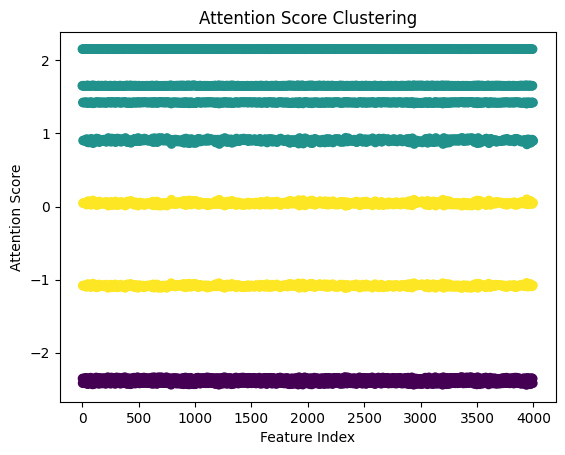

In [55]:
### Identify clusters of attention weights
from sklearn.cluster import KMeans

### cluster the attention scores across rows
kmeans = KMeans(n_clusters=3, random_state=0).fit(flattened_attention.reshape(-1, 1))
print(kmeans.labels_)
print(kmeans.cluster_centers_)
### print the length of each cluster
print(np.unique(kmeans.labels_, return_counts=True))


### plot the clusters
plt.scatter(range(len(flattened_attention)), flattened_attention, c=kmeans.labels_)
plt.xlabel('Feature Index')
plt.ylabel('Attention Score')
plt.title('Attention Score Clustering')
plt.show()






In [56]:
### print the feature index for each cluster
for i in range(3):
    print(f"Cluster {i+1} Feature Indices:", np.where(kmeans.labels_ == i)[0])

    

Cluster 1 Feature Indices: [   2    3   10   11   18   19   26   27   34   35   42   43   50   51
   58   59   66   67   74   75   82   83   90   91   98   99  106  107
  114  115  122  123  130  131  138  139  146  147  154  155  162  163
  170  171  178  179  186  187  194  195  202  203  210  211  218  219
  226  227  234  235  242  243  250  251  258  259  266  267  274  275
  282  283  290  291  298  299  306  307  314  315  322  323  330  331
  338  339  346  347  354  355  362  363  370  371  378  379  386  387
  394  395  402  403  410  411  418  419  426  427  434  435  442  443
  450  451  458  459  466  467  474  475  482  483  490  491  498  499
  506  507  514  515  522  523  530  531  538  539  546  547  554  555
  562  563  570  571  578  579  586  587  594  595  602  603  610  611
  618  619  626  627  634  635  642  643  650  651  658  659  666  667
  674  675  682  683  690  691  698  699  706  707  714  715  722  723
  730  731  738  739  746  747  754  755  762  763

In [57]:
### print the associated input index for cluster 3
cluster_3_indices = np.where(kmeans.labels_ == 2)[0]
print(len(cluster_3_indices))
print(cluster_3_indices)



1000
[   4    6   12   14   20   22   28   30   36   38   44   46   52   54
   60   62   68   70   76   78   84   86   92   94  100  102  108  110
  116  118  124  126  132  134  140  142  148  150  156  158  164  166
  172  174  180  182  188  190  196  198  204  206  212  214  220  222
  228  230  236  238  244  246  252  254  260  262  268  270  276  278
  284  286  292  294  300  302  308  310  316  318  324  326  332  334
  340  342  348  350  356  358  364  366  372  374  380  382  388  390
  396  398  404  406  412  414  420  422  428  430  436  438  444  446
  452  454  460  462  468  470  476  478  484  486  492  494  500  502
  508  510  516  518  524  526  532  534  540  542  548  550  556  558
  564  566  572  574  580  582  588  590  596  598  604  606  612  614
  620  622  628  630  636  638  644  646  652  654  660  662  668  670
  676  678  684  686  692  694  700  702  708  710  716  718  724  726
  732  734  740  742  748  750  756  758  764  766  772  774  780  782
 

In [58]:
#avg_attention
### get the top 3 features of avg_attention
print(model.embedding.weight[0])


tensor([ 7.0378e-01, -1.7340e+00, -1.3413e-01, -1.1924e+00, -5.6488e-02,
         1.9806e-01,  1.8049e+00, -5.6192e-04], grad_fn=<SelectBackward0>)


In [59]:
# After training
model.eval()
with torch.no_grad():
    predictions = model(inputs)
    #attention_weights = model.attention_weights  # List of attention weights for each layer


In [60]:
### convert experiments and outcomes to one hot encoded data
binary_input = experiments.values
one_hot_encoded = torch.nn.functional.one_hot(torch.tensor(binary_input), num_classes=2).numpy()
print(one_hot_encoded[0])
print(len(one_hot_encoded[0]), len(one_hot_encoded))


[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
28 2000


In [61]:
embedding = nn.Embedding(2, embedding_dim=4)
binary_tensor = torch.tensor(binary_input)
embedded_input = embedding(binary_tensor)
print(embedded_input[0])
print(len(embedded_input[0]), len(embedded_input))

tensor([[ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.5188, -1.4639,  0.5222, -0.8077],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190, -0.1314],
        [ 0.6625, -0.1846,  2.4190

In [62]:
sequence_representation = binary_input + 1
print(sequence_representation[0])
print(len(sequence_representation[0]), len(sequence_representation))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
28 2000


In [63]:
binary_tensor = torch.tensor(binary_input)
feature_groups = [[0,1],[2,3]]
multi_hot_encoded = torch.cat([binary_tensor[group] for group in feature_groups], dim=0)
print(multi_hot_encoded[0])
print(len(multi_hot_encoded[0]), len(multi_hot_encoded))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
28 4


In [64]:
binary_tensor = torch.tensor(binary_input)
print(binary_tensor.shape)
active_features = [torch.where(row==1)[0].tolist() for row in binary_tensor]
print(active_features[0])
print(len(active_features[0]), len(active_features))

torch.Size([2000, 28])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
15 2000


In [65]:
print(binary_tensor.shape[1])
print(num_features)

28


NameError: name 'num_features' is not defined

In [66]:
embedding_dim  = 32
binary_input = experiments.values
binary_tensor = torch.tensor(binary_input)
num_features = binary_tensor.shape[1]

embedding = nn.Embedding(num_features, embedding_dim)

aggregated_emebeddings = [
    embedding(torch.tensor(features)).mean(dim=0) if len(features) > 0 else torch.zeros(embedding_dim)
    for features in active_features
]

aggregated_emebeddings = torch.stack(aggregated_emebeddings)
print(aggregated_emebeddings.shape)

torch.Size([2000, 32])


In [67]:
print(f"Active features: {len(active_features)}")
count = 0
max_f = 0
for features in active_features:
    if any(f >= num_features or f < 0 for f in features):
        print(f"Invalid feature indices found: {len(features)}")              
    count += 1

print(count)


Active features: 2000
2000


In [68]:
class FeatureCombinationModel(nn.Module):
    def __init__(self, num_features, embedding_dim, output_dim):
        super(FeatureCombinationModel, self).__init__()
        self.embedding = nn.Embedding(num_features, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        # Aggregate embeddings of active features
        aggregated_embeddings = []
        for features in x:
            if len(features) > 0:
                feature_indices = torch.tensor(features)
                feature_indices = feature_indices.clamp(0, self.embedding.num_embeddings - 1)  # Clamp indices
                embeddings = self.embedding(feature_indices)
                aggregated_embeddings.append(embeddings.mean(dim=0))
            else:
                aggregated_embeddings.append(torch.zeros(self.embedding.embedding_dim))
        
        aggregated_embeddings = torch.stack(aggregated_embeddings)
        output = self.fc(aggregated_embeddings)
        return output

# Instantiate model
model = FeatureCombinationModel(num_features=num_features, embedding_dim=32, output_dim=1)

# Forward pass
output = model(active_features)
print(output)

tensor([[ 0.0944],
        [-0.1574],
        [ 0.0988],
        ...,
        [ 0.0016],
        [ 0.0904],
        [ 0.0904]], grad_fn=<AddmmBackward0>)


In [69]:
class AttentionFeatureModel(nn.Module):
    def __init__(self, num_features, embedding_dim, output_dim, num_heads=4):
        super(AttentionFeatureModel, self).__init__()
        self.embedding = nn.Embedding(num_features, embedding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        # Aggregate embeddings of active features
        max_len = max(len(features) for features in x)  # Find max sequence length
        padded_features = torch.zeros(len(x), max_len, self.embedding.embedding_dim)
        attention_mask = torch.ones(len(x), max_len) * -float('inf')  # Default mask for attention
        
        for i, features in enumerate(x):
            if len(features) > 0:
                feature_indices = torch.tensor(features)
                feature_indices = feature_indices.clamp(0, self.embedding.num_embeddings - 1)  # Clamp indices
                embeddings = self.embedding(feature_indices)
                
                # Fill padded features and attention mask
                padded_features[i, :len(embeddings), :] = embeddings
                attention_mask[i, :len(embeddings)] = 0  # Mask valid positions
        
        # Attention mechanism
        attn_output, attn_weights = self.attention(
            padded_features, 
            padded_features, 
            padded_features,
            key_padding_mask=attention_mask.bool()
        )
        aggregated = attn_output.mean(dim=1)  # Aggregate attention output

        # Output layer
        output = self.fc(aggregated)
        return output, attn_weights

# Instantiate model
attention_model = AttentionFeatureModel(num_features=num_features, embedding_dim=32, output_dim=1)



In [70]:
# Forward pass
output, weights = attention_model(active_features)
print(output, weights)

tensor([[ 0.0922],
        [ 0.0944],
        [-0.0011],
        ...,
        [-0.0497],
        [    nan],
        [    nan]], grad_fn=<AddmmBackward0>) tensor([[[0.0913, 0.0592, 0.0648,  ..., 0.0000, 0.0000, 0.0000],
         [0.0653, 0.0724, 0.0543,  ..., 0.0000, 0.0000, 0.0000],
         [0.0465, 0.0682, 0.0660,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0667, 0.0667, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0667, 0.0667, 0.0667,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0669, 0.0733, 0.0584,  ..., 0.0000, 0.0000, 0.0000],
         [0.1317, 0.0437, 0.0693,  ..., 0.0000, 0.0000, 0.0000],
         [0.1038, 0.0745, 0.0801,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0714, 0.0714, 0.0714,  ..., 0.0000, 0.0000, 0.0000],
         [0.0714, 0.0714, 0.0714,  ..., 0.0000, 0.0000, 0.0000],
         [0.0714, 0.0714, 0.0714,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0466, 0.0488, 0.0484, 

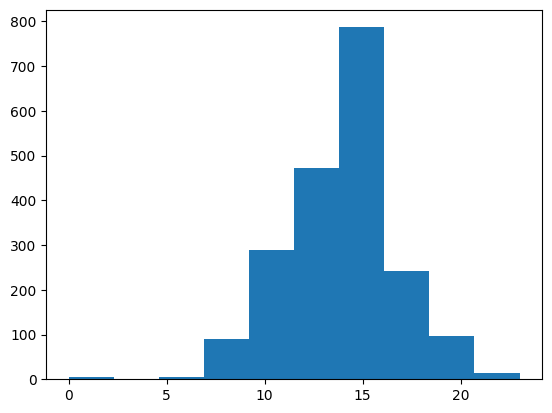

In [71]:
### plot histogram that represents the length of the active features
### get the length of each active feature
active_features_lengths = [len(row) for row in active_features]
plt.hist(active_features_lengths)
plt.show()

In [72]:
print(len(binary_input))
target_output = torch.tensor(df_results[0].values)
target_output = torch.tensor(target_output, dtype=torch.float32)
binary_tensor = torch.tensor(binary_input)



2000


/tmp/ipykernel_183331/13327173.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_output = torch.tensor(target_output, dtype=torch.float32)


In [73]:
dataset = TensorDataset(binary_tensor, target_output)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [74]:
import torch.optim as optim

output_dim = 1

# Example for FeatureCombinationModel
model = FeatureCombinationModel(num_features, embedding_dim, output_dim)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [75]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        # Prepare active_features from binary_input_batch
        active_features_batch = [
            torch.where(row == 1)[0].tolist() for row in binary_input_batch
        ]

        # Forward pass
        predictions = model(active_features_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")


Epoch 1/50, Loss: 17.91351120055668
Epoch 2/50, Loss: 13.039372126261393
Epoch 3/50, Loss: 8.027051751575772
Epoch 4/50, Loss: 3.92833288605251
Epoch 5/50, Loss: 1.8198341050791362
Epoch 6/50, Loss: 1.1998242440204772
Epoch 7/50, Loss: 1.0879476425193606
Epoch 8/50, Loss: 1.0647955470614963
Epoch 9/50, Loss: 1.0326196087731256
Epoch 10/50, Loss: 1.0160874941992382
Epoch 11/50, Loss: 0.9958580699231889
Epoch 12/50, Loss: 0.9774668164669521
Epoch 13/50, Loss: 0.9472459892904947
Epoch 14/50, Loss: 0.9183433472164093
Epoch 15/50, Loss: 0.8976292383103144
Epoch 16/50, Loss: 0.8784759624136819
Epoch 17/50, Loss: 0.8608186916699485
Epoch 18/50, Loss: 0.8558798706720746
Epoch 19/50, Loss: 0.8375489153559246
Epoch 20/50, Loss: 0.8295636359188292
Epoch 21/50, Loss: 0.8031887575274422
Epoch 22/50, Loss: 0.7927707251575258
Epoch 23/50, Loss: 0.7992686134955239
Epoch 24/50, Loss: 0.7759327890854033
Epoch 25/50, Loss: 0.7657521471144662
Epoch 26/50, Loss: 0.7609908476708427
Epoch 27/50, Loss: 0.7529

In [70]:
attn_model = AttentionFeatureModel(num_features, embedding_dim, output_dim)

criterion = nn.MSELoss()  # Loss function for regression
optimizer = optim.Adam(attn_model.parameters(), lr=0.001)  # Adjust learning rate if needed

In [71]:
num_epochs = 50

for epoch in range(num_epochs):
    attn_model.train()  # Set model to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = attn_model(binary_input_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

/tmp/ipykernel_919784/1566264484.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_indices = torch.tensor(features)


Epoch 1/50, Loss: 3.655454892638727
Epoch 2/50, Loss: 3.046500346445023
Epoch 3/50, Loss: 3.0730649313182696
Epoch 4/50, Loss: 3.0696944902974663
Epoch 5/50, Loss: 3.068758174459985
Epoch 6/50, Loss: 3.0727536885450917
Epoch 7/50, Loss: 3.0652347092932843
Epoch 8/50, Loss: 3.0431945845484734
Epoch 9/50, Loss: 3.044002404978089
Epoch 10/50, Loss: 3.0489693722615003
Epoch 11/50, Loss: 3.078918237424066
Epoch 12/50, Loss: 3.059096540330995
Epoch 13/50, Loss: 3.0629026344481933
Epoch 14/50, Loss: 3.0572465205868933
Epoch 15/50, Loss: 3.065705267461479
Epoch 16/50, Loss: 3.0773804445638726
Epoch 17/50, Loss: 3.0465139873484346
Epoch 18/50, Loss: 3.052098202789929
Epoch 19/50, Loss: 3.056984438963816
Epoch 20/50, Loss: 3.0559719855903733
Epoch 21/50, Loss: 3.0674190379626363
Epoch 22/50, Loss: 3.0647737430342548
Epoch 23/50, Loss: 3.061633567438058
Epoch 24/50, Loss: 3.0607317844603923
Epoch 25/50, Loss: 3.042762963695729
Epoch 26/50, Loss: 3.061188892269811
Epoch 27/50, Loss: 3.067203262596

In [100]:
attn_model

AttentionFeatureModel(
  (embedding): Embedding(2295, 32)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [76]:
### Save the attn_model to file
torch.save(attn_model.state_dict(), 'attn_model.pth')
torch.save(model.state_dict(), 'feature_model.pth')



In [111]:
attn_model = AttentionFeatureModel(num_features, embedding_dim, output_dim)

### Load the model from file
attn_model.load_state_dict(torch.load('attn_model.pth'))
### laod the feature model from file
model.load_state_dict(torch.load('feature_model.pth'))


/tmp/ipykernel_919784/1738869584.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_model.load_state_dict(torch.load('attn_model.pth'))
/tmp/ipykernel_919784/173886958

<All keys matched successfully>

In [112]:
attn_model.eval()

AttentionFeatureModel(
  (embedding): Embedding(2295, 32)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [113]:
### predict a single scenario
scenario = torch.tensor(binary_input[1])
active_features = torch.where(scenario == 1)[0].tolist()
print(active_features)
predictions = attn_model([active_features])
print(predictions)




[16, 30, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
(tensor([[0.5937]], grad_fn=<AddmmBackward0>), tensor([[[0.0069, 0.0055, 0.0031,  ..., 0.0093, 0.0088, 0.0133],
         [0.0080, 0.0083, 0.0071,  ..., 0.0101, 0.0128, 0.0119],
         [0.0106, 0.0110, 0.0254,  ..., 0.0055, 0.0051, 0.0063],
         ...,
         [0.0124, 0.0099, 0.0117,  ..., 0.0084, 0.0109, 0.0081],
         [0.0065, 0.0054, 0.0308,  ..., 0.0070, 0.0046, 0.0029],
         [0.0093, 0.0053, 0.0056,  ..., 0.0146, 0.0130, 0.0106]]],
       grad_fn=<MeanBackward1>))


In [114]:
embedding_weights = model.embedding.weight.detach().cpu().numpy()

print("Embedding wewights shape:", embedding_weights.shape)

Embedding wewights shape: (2295, 32)


In [115]:
t_binary_input = torch.tensor(binary_input, dtype=torch.int64)

In [116]:
t_binary_input

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [117]:
attn_model.eval()
with torch.no_grad():
    input_example = t_binary_input[0].unsqueeze(0)  # Single input
    transformer_output, attention_weights = attn_model(input_example)
    print("Attention weights shape:", attention_weights.shape)

Attention weights shape: torch.Size([1, 2295, 2295])


/tmp/ipykernel_919784/2060239279.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_indices = torch.tensor(features)


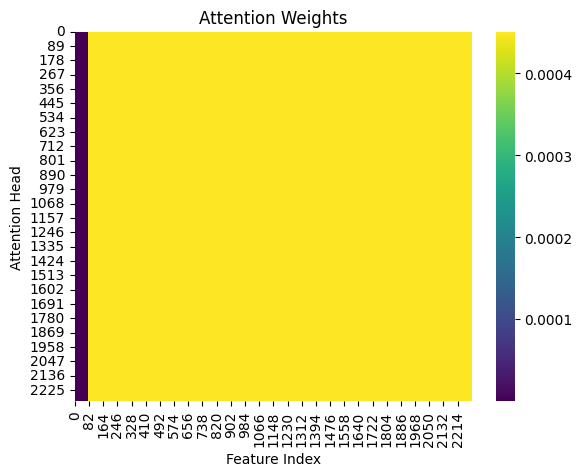

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume attention_weights is of shape (1, num_features) or (num_heads, num_features)
attention_weights_np = attention_weights.squeeze().numpy()  # Remove batch dimension

sns.heatmap(attention_weights_np, cmap="viridis")
plt.title("Attention Weights")
plt.xlabel("Feature Index")
plt.ylabel("Attention Head")
plt.show()

In [120]:
attention_weights_np[0]

array([1.0466510e-09, 1.0466510e-09, 1.0466510e-09, ..., 4.5105990e-04,
       4.5105990e-04, 4.5105995e-04], dtype=float32)

In [159]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.5]]
low_results = df_results[df_results[0] <= quantileDF[0.5]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.5]]
low_inputs = experiments[df_results[0] <= quantileDF[0.5]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))

4499
4499
4499
4499


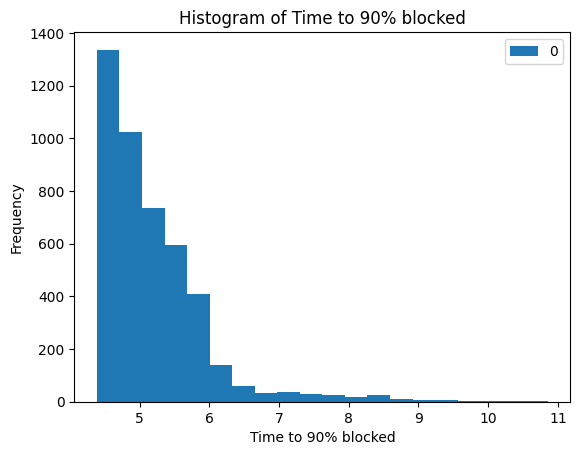

In [161]:
### Plot histogram of df_results[0]
high_results.plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()

In [21]:
print(df.shape)
print(df_results.shape)

(8998, 2295)
(8998, 1)


In [162]:
### create an x and y from df and df_results
X = high_inputs.values
y = high_results.values

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [163]:
print(f"X_train_tensor shape: {X_train_tensor.shape}")  # Expected: (train_samples, num_features)
print(f"y_train_tensor shape: {y_train_tensor.shape}")  # Expected: (train_samples, 1)
print(f"X_test_tensor shape: {X_test_tensor.shape}")    # Expected: (test_samples, num_features)
print(f"y_test_tensor shape: {y_test_tensor.shape}")    # Expected: (test_samples, 1)


X_train_tensor shape: torch.Size([3599, 2295])
y_train_tensor shape: torch.Size([3599, 1, 1])
X_test_tensor shape: torch.Size([900, 2295])
y_test_tensor shape: torch.Size([900, 1, 1])


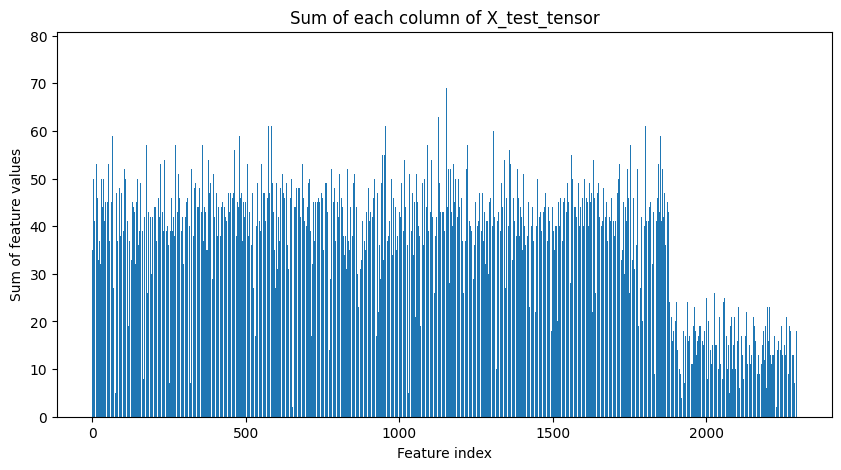

In [164]:
### plot sum of each column of X_test_tensor
plt.figure(figsize=(10, 5))
plt.bar(range(X_test_tensor.shape[1]), X_test_tensor.sum(dim=0))
plt.xlabel("Feature index")
plt.ylabel("Sum of feature values")
plt.title("Sum of each column of X_test_tensor")
plt.show()


In [165]:
num_epochs = 10

for epoch in range(num_epochs):
    attn_model.train()  # Set model to training mode
    epoch_loss = 0

    for binary_input_batch, target_output_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = attn_model(binary_input_batch)
        loss = criterion(predictions.squeeze(), target_output_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

In [166]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, output_dim, max_len=5000):
        super(TransformerRegressor, self).__init__()
        # Linear layer to project input_dim to d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output regression layer
        self.regressor = nn.Linear(d_model, output_dim)

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debug input shape

        # Project input to d_model dimension
        x = self.embedding(x)  # Shape: (batch_size, seq_len, d_model)

        # Add positional encoding
        x = self.positional_encoding(x)  # Shape: (batch_size, seq_len, d_model)

        # Transformer expects input of shape (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, d_model)

        # Pass through the transformer
        x = self.transformer(x)  # Shape: (seq_len, batch_size, d_model)

        # Aggregate along the sequence dimension (mean pooling)
        x = x.permute(1, 0, 2).mean(dim=1)  # Shape: (batch_size, d_model)

        # Final regression layer
        x = self.regressor(x)  # Shape: (batch_size, output_dim)
        return x

    def _positional_encoding(self, x):
        # Positional encoding for feature dimension
        seq_len, d_model = x.size(1), x.size(2)
        pe = torch.zeros(1, seq_len, d_model)
        for pos in range(seq_len):
            for i in range(0, d_model, 2):
                pe[0, pos, i] = torch.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[0, pos, i + 1] = torch.cos(pos / (10000 ** ((2 * i) / d_model)))
        return pe.to(x.device)

In [167]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        print(f"Input x type: {type(x)} and shape: {x.shape}")
        seq_len = x.size(1)  # Match sequence length
        encoding = self.encoding[:, :seq_len, :].to(x.device)
        return encoding

In [168]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [169]:
import math

x = torch.rand(32, 10, 128)
pe = PositionalEncoding(d_model=128)
pos_encoded = pe(x)
print(pos_encoded.shape)  # Expected: (32, 10, 128)

Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 10, 128])
torch.Size([1, 10, 128])


In [170]:
X_train_tensor.shape

torch.Size([3599, 2295])

In [171]:
input_dim = X.shape[1]
output_dim = 1

In [172]:
def forward(self, x):
    print(f"Input shape: {x.shape}")  # Debug
    
    # Add sequence dimension if missing
    if len(x.shape) == 2:  # (batch_size, input_dim)
        x = x.unsqueeze(1)  # (batch_size, 1, input_dim)
    
    x = self.embedding(x)  # Linear layer to match d_model
    print(f"After embedding: {x.shape}")  # Debug
    
    # Apply positional encoding
    pos_enc = self._positional_encoding(x)  # Generate positional encoding
    print(f"Positional encoding shape: {pos_enc.shape}")  # Debug
    
    x = x + pos_enc  # Add positional encoding
    print(f"After positional encoding: {x.shape}")  # Debug
    
    x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
    x = self.transformer(x)  # Transformer processing
    x = x.permute(1, 0, 2).mean(dim=1)  # Back to (batch_size, d_model)
    x = self.regressor(x)  # (batch_size, output_dim)
    return x





In [173]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(input_dim=input_dim, d_model=512, num_heads=16, num_layers=8, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()



#forward(model, X_train_tensor[:2])


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [174]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])


/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x ty

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x ty

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Train Loss: 0.9308, Test Loss: 0.4969
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 512])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 5

TransformerRegressor(
  (embedding): Linear(in_features=2295, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)

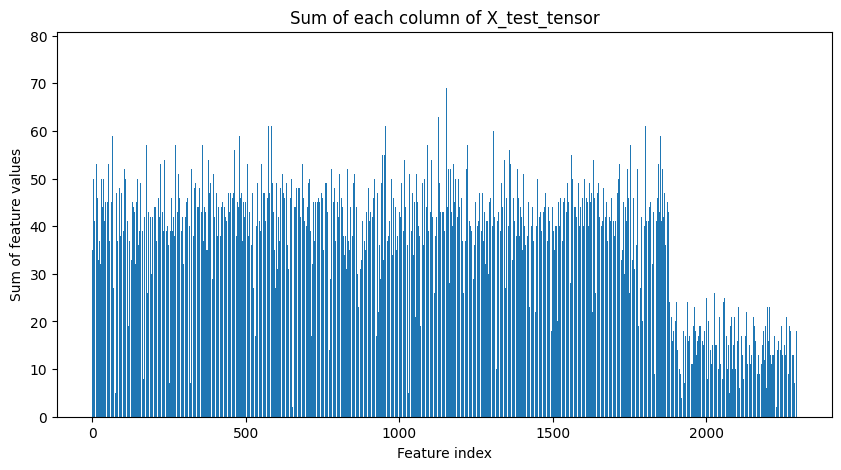

In [175]:
### Plot the sum of each column of X_test_tensor
plt.figure(figsize=(10, 5))
plt.bar(range(X_test_tensor.shape[1]), X_test_tensor.sum(dim=0))
plt.xlabel("Feature index")
plt.ylabel("Sum of feature values")
plt.title("Sum of each column of X_test_tensor")
plt.show()

In [184]:
### create an example input of all 1s
example_ones_input = torch.ones(1, X_test_tensor.shape[1])
### create an example input of all 0s
example_zeros_input = torch.zeros(1, X_test_tensor.shape[1])

model.eval()
with torch.no_grad():
    example_output = model(example_ones_input)
    print(f"Example output: {example_output.item()}")

    example_output = model(example_zeros_input)
    print(f"Example output: {example_output.item()}")

print(example_ones_input)
print(example_zeros_input)

Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Example output: 5.364516735076904
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Example output: 5.364516735076904
tensor([[1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


In [176]:
y_true = y_test_tensor.squeeze().numpy()
predictions = []
with torch.no_grad():
    model.eval()
    for i in range(X_test_tensor.shape[0]):
        sample = X_test_tensor[i].unsqueeze(0)
        pred = model(sample)
        pred = pred.squeeze().item()
        predictions.append(pred)    

Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([1, 512])
Input shape: torch.Size([1, 2295])
Input x type: <class 'torch.T

In [177]:
print(len(predictions), len(y_true))

900 900


In [181]:
predictions

[5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,
 5.364516735076904,


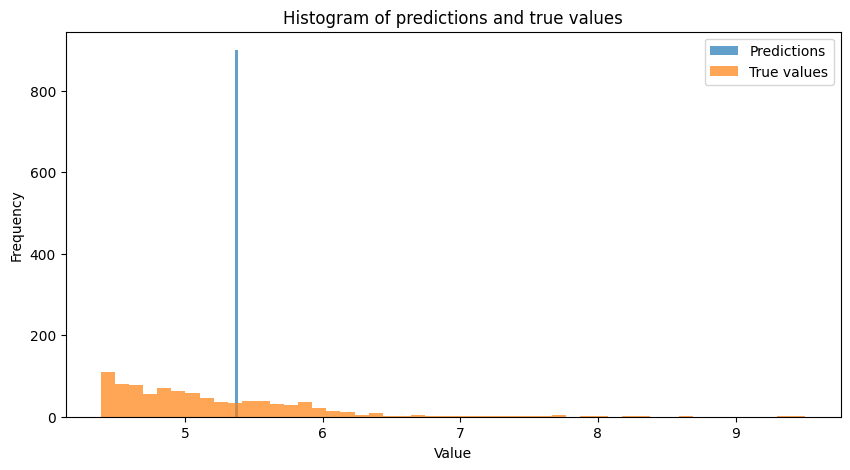

In [179]:
### plot histogram of predictions
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=50, alpha=0.7, label="Predictions")
plt.hist(y_true, bins=50, alpha=0.7, label="True values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of predictions and true values")
plt.legend()
plt.show()


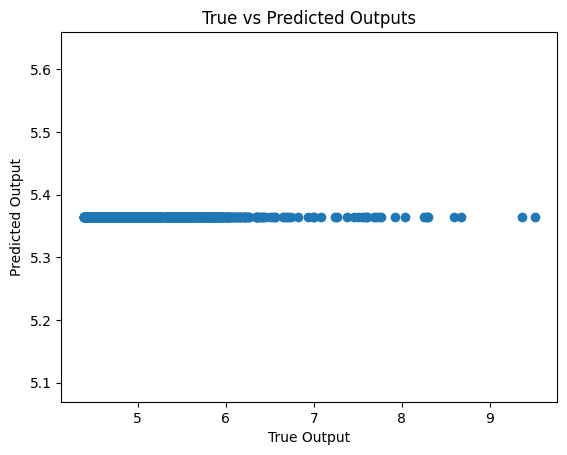

In [180]:
import matplotlib.pyplot as plt

plt.scatter(y_test_tensor, predictions)
plt.xlabel("True Output")
plt.ylabel("Predicted Output")
plt.title("True vs Predicted Outputs")
plt.show()


In [134]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        all_preds = []
        all_targets = []
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            all_preds.append(output)
            all_targets.append(target)
        
        # Calculate Mean Squared Error
        test_loss /= len(test_loader)
        print(f'Test Loss: {test_loss}')

        # Convert list to tensors
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        return all_preds, all_targets

# Evaluate the model
predictions, targets = evaluate_model(model, test_loader)


Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x type: <class 'torch.Tensor'> and shape: torch.Size([32, 128])
Input shape: torch.Size([32, 2295])
Input x ty

In [135]:
predictions

array([[4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.28131],
       [4.